Importing The Libraries

In [22]:
import numpy as np 
import pandas as pd 
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import math
from sklearn.preprocessing import MinMaxScaler
plt.style.use('fivethirtyeight')

Importing The Dataset

In [23]:
parser=lambda x: pd.datetime.strptime(x, '%b %d, %Y')
df=pd.read_csv('CrudeOilPrices.csv',parse_dates=['Date'], date_parser=parser)
df=df.sort_values('Date')
df=df.groupby('Date')['Price'].sum().reset_index()
df.set_index('Date', inplace=True)
df=df.loc[datetime.date(year=2000,month=1,day=1):]
df.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,Price
Date,
2000-01-04,23.95
2000-01-05,23.72
2000-01-06,23.55
2000-01-07,23.35
2000-01-10,22.77
2000-01-11,23.93
2000-01-12,24.62
2000-01-13,24.90
2000-01-14,25.50


Handling Missing Data

In [24]:
df.isnull().sum()

Price    0
dtype: int64

In [ ]:
#There is no null value

Data Visualization

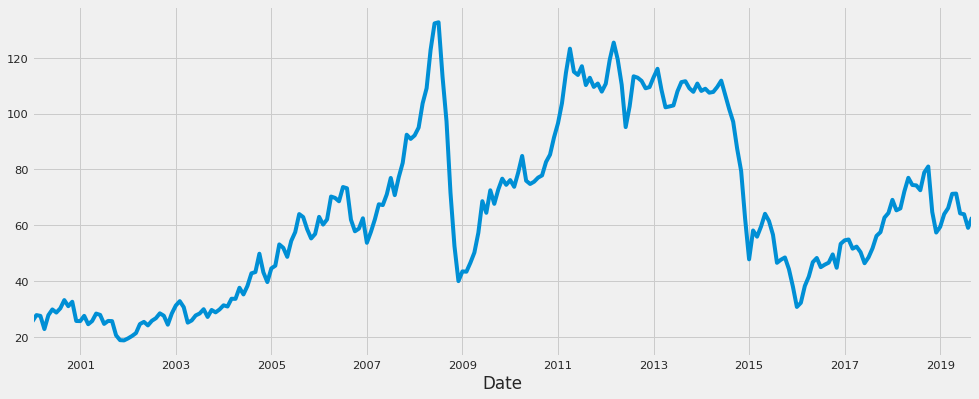

In [25]:
y = df['Price'].resample('MS').mean()
y.plot(figsize=(15, 6))
plt.show()

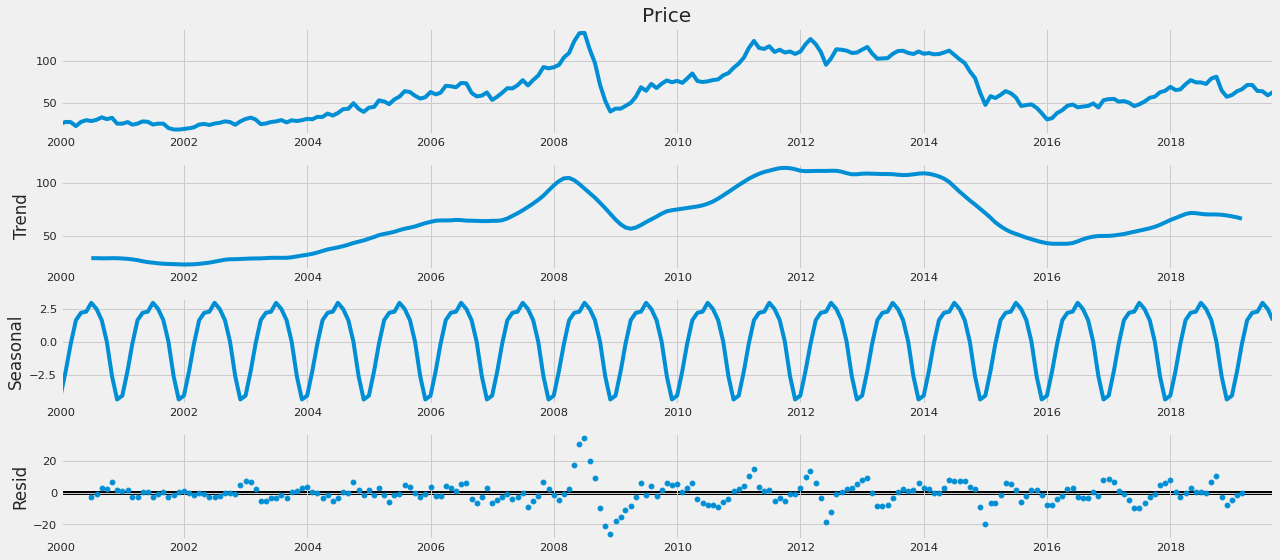

In [26]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Feature Scaling

In [27]:
sc = MinMaxScaler(feature_range = (0, 1))
df=sc.fit_transform(df)

Splitting Data Into Train And Test

In [28]:
train_set_length=int(len(df) * 0.70)
test_set_length=len(df)-train_set_length
train,test=df[0:train_set_length,:],df[train_set_length:len(df),:]

Creating a dataset with sliding window

In [29]:
def create_data_set(_data_set,_look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set)-_look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [30]:
look_back=10
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))

Importing Model Libraries

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Initializing The Model, Adding LSTM Layers, Adding Output Layers,Configuring The Learning Process

In [32]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(LSTM(units = 50))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

Train The Model

In [33]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 15,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/20
234/234 [==============================] - 14s 28ms/step - loss: 0.0039 - val_loss: 0.0506 - lr: 0.0010
Epoch 2/20
234/234 [==============================] - 6s 28ms/step - loss: 0.0112 - val_loss: 0.0631 - lr: 0.0010
Epoch 3/20
234/234 [==============================] - 7s 31ms/step - loss: 0.0120 - val_loss: 0.0715 - lr: 0.0010
Epoch 4/20
234/234 [==============================] - 5s 21ms/step - loss: 0.0177 - val_loss: 0.0816 - lr: 0.0010
Epoch 5/20
234/234 [==============================] - 6s 25ms/step - loss: 0.0214 - val_loss: 0.0595 - lr: 0.0010
Epoch 6/20
234/234 [==============================] - 5s 22ms/step - loss: 0.0098 - val_loss: 0.0057 - lr: 0.0010
Epoch 7/20
234/234 [==============================] - 5s 21ms/step - loss: 0.0014 - val_loss: 0.0012 - lr: 0.0010
Epoch 8/20
234/234 [==============================] - 5s 22ms/step - loss: 0.0010 - val_loss: 0.0031 - lr: 0.0010
Epoch 9/20
234/234 [==============================] - 5s 21ms/step - loss: 0.0012 - val

Testing The Model

In [34]:
test_predict=regressor.predict(X_test)

47/47 [==============================] - 2s 7ms/step


Model Evaluation

In [35]:
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

Mean Absolute Error: 2.1092967999827272
Mean Squared Error: 2.654637673385558


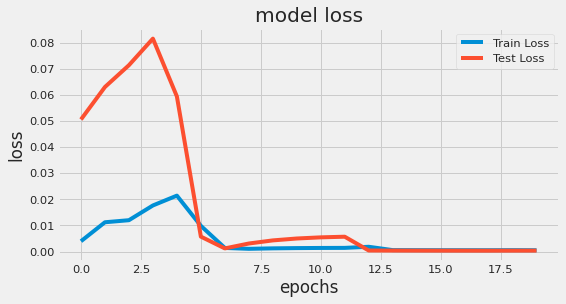

In [36]:
print('Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

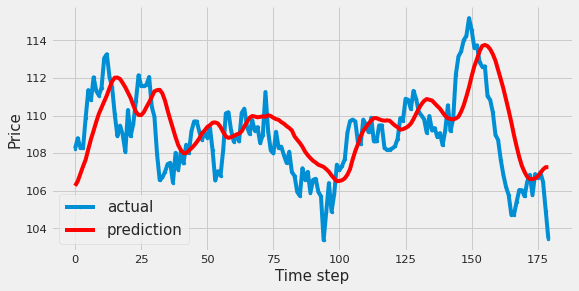

In [37]:
aa=[x for x in range(180)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:180], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:180], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

Save The Model

In [38]:
regressor_json = regressor.to_json()
with open("regressor.json", "w") as json_file:
    json_file.write(regressor_json)
regressor.save("regressor.h5")

In [39]:
import joblib
scaler_filename="minmaxscaler.save"
joblib.dump(sc,scaler_filename)

['minmaxscaler.save']